# Introduction

In this project, we study some examples to recover system dynamics from pure state measurements. For now our focus is on simple damped systems. We study three cases:

1. 2D damped oscillator with linear dynamics
2. 2D damped oscillator with cubic nonlinearities
3. 3D damped oscillator with linear dynamics

In this project, we assume the velocities are without noise from differentiation of state measurements. In the upcoming projects, we also consider the effect of noise in measurements as well.  To gain some knowledge on the theory behind this code see:
 https://www.pnas.org/action/downloadSupplement?doi=10.1073%2Fpnas.1517384113&file=pnas.1517384113.sapp.pdf

For each state measrement, we consider a library of base functions. For the three examples studied here we consider only polynomials until a predefined degree. For instance if the system has two states and we consider a polynomial base up to degree 2, for a measuremnt of $x_1$ and $x_2$ we have:

[1, $x_1$, $x_2$, $x_1^2$, $x_2^2$, $x_1 x_2$]

In [1]:
import numpy as np
import matplotlib.pyplot as plt

First, we define functions that output a base of polynomial function for systems with 2 or 3 states.

In [2]:
def  polynomialBase_2States(x, y, n):

  polynomialVector = np.array([]);
  for i in range(n + 1):
      for j in range(i + 1):
        m = i - j;
        #polynomialVector = [polynomialVector j k m];
        tempVal = np.power(x,j)* np.power(y,m)
        polynomialVector = np.append(polynomialVector, tempVal);


  return polynomialVector

In [3]:
def  polynomialBase_3States(x, y, z, n):

  polynomialVector = np.array([]);
  for i in range(n + 1):
      for j in range(i + 1):
          for k in range(i + 1):
              m = i - j - k;
              if m >= 0:
                  #polynomialVector = [polynomialVector j k m];
                  tempVal = np.power(x,j)* np.power(y,k) * np.power(z, m)
                  polynomialVector = np.append(polynomialVector, tempVal);


  return polynomialVector

Now, we consider a case with 0.002 s sampling time to measure the states. We make measurements for 25 seconds. For each state measurement, we store the polynomial bases up to degree 5 in a state matrix XX. Also, we use simple differentiation to estimate the rate of change of states.

In [4]:
TEnd_Simulation = 25;
Ts_Simulation = 0.001 # sampling time for the original data
Ts_Measurement = 0.002 # sampling time for the state measurement
simTime_Simulation = np.arange(Ts_Simulation, Ts_Simulation + TEnd_Simulation, Ts_Simulation)# Original data simulation time vector
simTime_Measurement = np.arange(Ts_Measurement, Ts_Measurement + TEnd_Simulation, Ts_Measurement) # Data Measurement time vector



In [5]:
def oscillator2D(X, t):

  dynamicsMatrix = np.array([[-0.1, 2],[-2, -0.1]])
  dXdt = np.dot(dynamicsMatrix, X)
  return dXdt

In [6]:
def oscillator2D_Cubic(X, t):

  dynamicsMatrix = np.array([[-0.1, 1],[-1, -0.1]])
  dXdt = np.dot(dynamicsMatrix, np.power(X, 3))
  return dXdt

In [28]:
def oscillator3D(X, t):

  dynamicsMatrix = np.array([[-0.1, -2, 0],[2, -0.1, 0],[0, 0, -0.3]])
  dXdt = np.dot(dynamicsMatrix, X)
  return dXdt

In [15]:
from scipy.integrate import odeint

def dynamicsEvolution(inputFunc, X_0, simTime_Simulation, Ts_Measurement):

  X_prev_measured = np.copy(X_0)
  XX_List = [] # XX: Polynomial base State Matrix. This matrix contains all powers of states at each time instant [1 X_1 X_2 X_3 X_1^2 X_2^2 X_3^2 X1X2 X1X3 X2X3 ...]
  dXdt_List = [] # Initialize vector of velocities
  tol = 1e-10
  stateDim = dynamicsMatrix.shape[0]

  X = odeint(inputFunc, X_0, simTime_Simulation)

  for i in range(1, simTime_Simulation.shape[0]):

    tempRatio = simTime_Simulation[i]/Ts_Measurement
    if np.isclose(tempRatio, round(tempRatio), atol=1e-10):
      #print(simTime_Simulation[i])
      if stateDim == 2:
        tempPolyBase = polynomialBase_2States(X[i,0], X[i,1], polyDeg)
      else:
        tempPolyBase = polynomialBase_3States(X[i,0], X[i,1], X[i,2], polyDeg)

      XX_List.append(tempPolyBase)
      tempdXdt = (X[i,:] - X_prev_measured)/Ts_Measurement
      dXdt_List.append(tempdXdt)
      X_prev_measured = np.copy(X[i,:]);

  XX = np.array(XX_List)
  dXdt = np.array(dXdt_List)
  return X, XX, dXdt


# compute Sparse regression: sequential least squares

Despite the large size of the measurement matrix XX, we assume that the coefficients matrix is sparse and can be recovered with some optimization that imposes sparsity.

One solution is L1 norm minimization (LASSO) which is quite expensive given the size of the measrement matrix. We use a smart method through succesive least-squares by making zero the solutions that are smaller than a threshold gamma.


In [9]:
def sparseRegression(XX, dXdt, gamma):
  Xi, residuals, rank, s = np.linalg.lstsq(XX, dXdt, rcond = None) # initial guess: Least-squares
  gamma = 0.01 # gamma is our sparsification knob.
  stateDim = dXdt.shape[1]

  for k in range(10): # 10 iterations for the sequential least-squares
    smallinds = (abs(Xi) < gamma) # find small coefficients
    Xi[smallinds] = 0;
    for ind in range(stateDim):
      biginds = ~smallinds[:,ind]
      # Regress dynamics onto remaining terms to find sparse Xi
      Xi[biginds,ind], residuals, rank, s = np.linalg.lstsq(XX[:,biginds], dXdt[:,ind], rcond = None)

  return Xi

## Data Recovery

In [10]:
def recoverSystemStates(XX, Xi, X_0, polyDeg):
  XRecovered_List = []
  XRecovered_List.append(X_0)
  cols = Xi.shape[1]
  for i in range(1,XX.shape[0]):
    XRecovered_prev = XRecovered_List[-1]
    if cols == 2:
      tempPolyBase = polynomialBase_2States(XRecovered_prev[0], XRecovered_prev[1], polyDeg);
    else:
      tempPolyBase = polynomialBase_3States(XRecovered_prev[0], XRecovered_prev[1],  XRecovered_prev[2], polyDeg);
    dXRecovered = Xi.T @ tempPolyBase.T
    XRecovered_New = XRecovered_List[-1] + dXRecovered * Ts_Measurement
    XRecovered_List.append(XRecovered_New)

  XRecovered = np.array(XRecovered_List)

  return XRecovered

# Example 1: 2D Linear Damped Oscillator

We consider a system with the governing equation as:

$\frac{dX}{dt} =
\begin{bmatrix}
-0.1 & 2 \\
-2 & -0.1 \\
\end{bmatrix}
$

In [17]:
dynamicsMatrix = np.array([[-0.1, 2],[-2, -0.1]]) # System dynamics matrix
polyDeg = 5
X_0 = np.array([2, 0])# Initial condition of the system


X, XX, dXdt = dynamicsEvolution(oscillator2D, X_0, simTime_Simulation, Ts_Measurement)


gamma = 0.01;
Xi = sparseRegression(XX, dXdt, gamma)
Xi
#X.shape

array([[ 0.        ,  0.        ],
       [ 2.0003966 , -0.09597048],
       [-0.09596972, -1.9995892 ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ]])

We see that the coefficients of the dynamic equation of the system are recovered with less than 7% error. We now use these results to recover the data.

In [18]:
# Recover data
XRecovered = recoverSystemStates(XX, Xi, X_0, polyDeg)

## Plots for Example 1



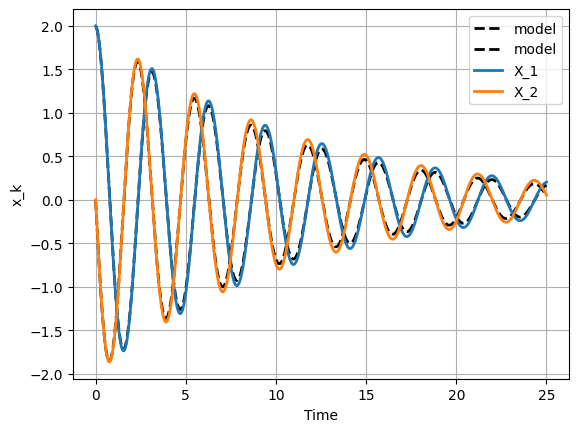

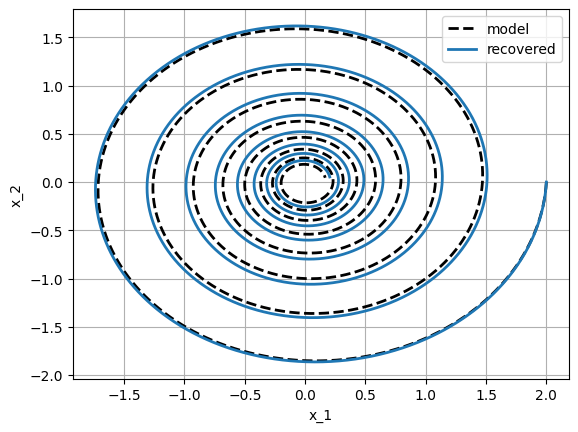

In [20]:
fig1 = plt.figure()
plt.plot(simTime_Simulation, X[:,0], linewidth = 2, linestyle ="--", color = "black", label = "model")
plt.plot(simTime_Simulation, X[:,1], linewidth = 2, linestyle ="--", color = "black", label = "model")

plt.plot(simTime_Measurement, XRecovered[:,0], linewidth = 2, label = "X_1")
plt.plot(simTime_Measurement, XRecovered[:,1], linewidth = 2, label = "X_2")

plt.grid()
plt.xlabel("Time")
plt.ylabel("x_k")
plt.legend()

fig2 = plt.figure()
plt.plot(X[:,0], X[:,1], linewidth = 2, label = "model", linestyle = "--", color = "black")
plt.plot(XRecovered[:,0], XRecovered[:,1],  linewidth = 2, label = "recovered")
plt.grid
plt.xlabel("x_1")
plt.ylabel("x_2")
plt.grid()
plt.legend()

# Example 2: 2D Damped Oscillator with Cubic Nonlinearity

$\frac{dX}{dt} =
\begin{bmatrix}
-0.1 & 1 \\
-1 & -0.1 \\
\end{bmatrix}
\begin{bmatrix}
x_1^3 \\
x_2^3 \\
\end{bmatrix}$

In [22]:
dynamicsMatrix = np.array([[-0.1, 1],[1, -0.1]]) # System dynamics matrix
polyDeg = 5
X_0 = np.array([2, 0])# Initial condition of the system


X, XX, dXdt = dynamicsEvolution(oscillator2D_Cubic, X_0, simTime_Simulation, Ts_Measurement)


gamma = 0.08;
Xi = sparseRegression(XX, dXdt, gamma)
Xi


array([[ 0.        ,  0.01776213],
       [ 0.        ,  0.03363488],
       [ 0.        ,  0.        ],
       [ 0.        , -0.05960651],
       [ 0.        , -0.01979551],
       [ 0.        , -0.05172258],
       [ 1.00041451, -0.18067724],
       [ 0.        , -0.03174579],
       [ 0.        , -0.07507475],
       [-0.0979019 , -0.99616294],
       [ 0.        ,  0.03631145],
       [ 0.        ,  0.01417452],
       [ 0.        ,  0.04787015],
       [ 0.        ,  0.02361961],
       [ 0.        ,  0.02594834],
       [ 0.        ,  0.03524336],
       [ 0.        ,  0.01527241],
       [ 0.        ,  0.0391396 ],
       [ 0.        ,  0.02715044],
       [ 0.        ,  0.04216763],
       [ 0.        ,  0.        ]])

In [23]:
# Recover data
XRecovered = recoverSystemStates(XX, Xi, X_0, polyDeg)

## Plots for Example 2

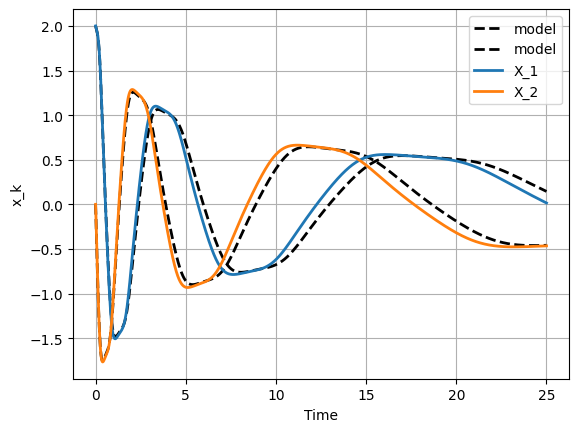

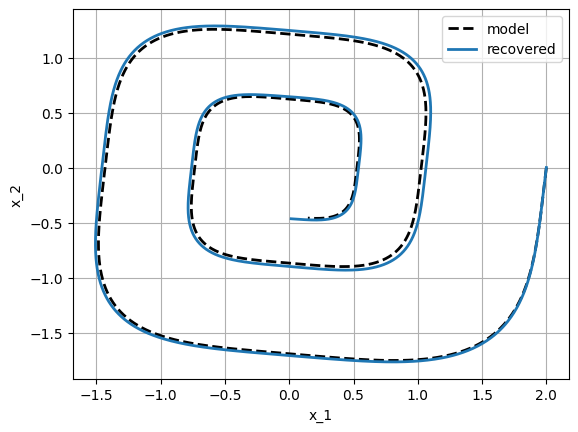

In [24]:
fig1 = plt.figure()
plt.plot(simTime_Simulation, X[:,0], linewidth = 2, linestyle ="--", color = "black", label = "model")
plt.plot(simTime_Simulation, X[:,1], linewidth = 2, linestyle ="--", color = "black", label = "model")

plt.plot(simTime_Measurement, XRecovered[:,0], linewidth = 2, label = "X_1")
plt.plot(simTime_Measurement, XRecovered[:,1], linewidth = 2, label = "X_2")

plt.grid()
plt.xlabel("Time")
plt.ylabel("x_k")
plt.legend()

fig2 = plt.figure()
plt.plot(X[:,0], X[:,1], linewidth = 2, label = "model", linestyle = "--", color = "black")
plt.plot(XRecovered[:,0], XRecovered[:,1],  linewidth = 2, label = "recovered")
plt.grid
plt.xlabel("x_1")
plt.ylabel("x_2")
plt.grid()
plt.legend()

# Example 3: 3D Linear Damped Oscillator

We consider a system with the governing equation as:

$\frac{dX}{dt} =
\begin{bmatrix}
-0.1 & 2 & 0 \\
-2 & -0.1 &0 \\
0 & 0& -0.3 \\
\end{bmatrix}
X$

In [29]:
dynamicsMatrix = np.array([[-0.1, -2, 0],[2, -0.1, 0],[0, 0, -0.3]]) # System dynamics matrix
polyDeg = 2
X_0 = np.array([2, 0, 1])# Initial condition of the system


X, XX, dXdt = dynamicsEvolution(oscillator3D, X_0, simTime_Simulation, Ts_Measurement)


gamma = 0.01;
Xi = sparseRegression(XX, dXdt, gamma)
Xi

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.29991004],
       [-2.0003966 , -0.09597048,  0.        ],
       [-0.09596972,  1.9995892 ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]])

We observe that the coefficients are recovered with less than 4% error. You can check what happens if we increase the degree of the polynomial base.

In [30]:
# Recover data
XRecovered = recoverSystemStates(XX, Xi, X_0, polyDeg)

# Plots for Example 3

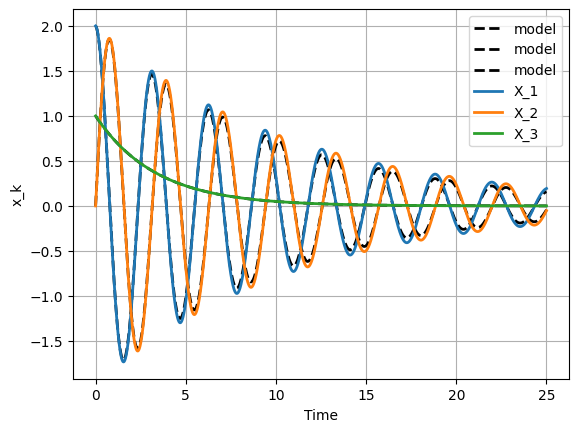

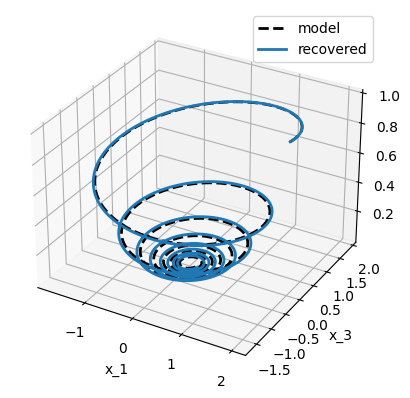

In [31]:
fig1 = plt.figure()
plt.plot(simTime_Simulation, X[:,0], linewidth = 2, linestyle ="--", color = "black", label = "model")
plt.plot(simTime_Simulation, X[:,1], linewidth = 2, linestyle ="--", color = "black", label = "model")
plt.plot(simTime_Simulation, X[:,2], linewidth = 2, linestyle ="--", color = "black", label = "model")

plt.plot(simTime_Measurement, XRecovered[:,0], linewidth = 2, label = "X_1")
plt.plot(simTime_Measurement, XRecovered[:,1], linewidth = 2, label = "X_2")
plt.plot(simTime_Measurement, XRecovered[:,2], linewidth = 2, label = "X_3")

plt.grid()
plt.xlabel("Time")
plt.ylabel("x_k")
plt.legend()

fig2 = plt.figure()
ax = fig2.add_subplot(111, projection='3d')
plt.plot(X[:,0], X[:,1], X[:, 2], linewidth = 2, label = "model", linestyle = "--", color = "black")
plt.plot(XRecovered[:,0], XRecovered[:,1], XRecovered[:,2], linewidth = 2, label = "recovered")
plt.grid
plt.xlabel("x_1")
plt.ylabel("x_2")
plt.ylabel("x_3")
plt.legend()